In [2]:
import pandas as pd 
import numpy as np
import math
import random
import sklearn.datasets

In [3]:
sklearn.datasets.make_spd_matrix(2)

array([[ 2.22543452, -0.85963102],
       [-0.85963102,  1.20036952]])

In [4]:

def get_pos_def_mean_cov(num_att):
    cov = sklearn.datasets.make_spd_matrix(num_att)
    mean, cov = get_mean_cov(num_att)
    while not is_pos_def(cov):
         mean, cov = get_mean_cov(num_att)
    return mean, cov


In [36]:

def get_pos_def_mean_cov(num_att):
    cov = sklearn.datasets.make_spd_matrix(num_att)
    mean = [2* (random.random() - 0.5) for _ in range(num_att)]
    return mean, cov


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# clip rows above b in the dataframe
def clip_data(df, b):
    for i, row in df.iterrows():
        cur_norm = np.linalg.norm(row.to_numpy())
        if cur_norm > b:
            df.at[i] = row * b / cur_norm

def union_sensitivity(b):
    return math.sqrt(4*b**4 + 4*b**2)

def join_sensitivity(b):
    return max(math.sqrt(4*b**4 + 4*b**2), math.sqrt(2 + 2*B**2 + 2*B**4))
            
# iterate each row of df and compute the largest l2 norm
def get_l2_bound(df):
    max_bound = 0
    for _, row in df.iterrows():
        cur_bound = 0
        for col in df.columns:
            cur_bound += row[col]**2
        max_bound = max(max_bound, cur_bound)
    return max_bound ** 0.5

def get_l2_distance(a, b):
    return np.linalg.norm(a - b)

def get_cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [37]:
# std of natural distirbution for guassian noises
def compute_std(eps, delta, sensitivity=1):
    return (2*math.log(1.25/delta))**0.5*sensitivity/eps

# return the coefficients of features and a constant 
def ridge_linear_regression(cov_matrix, features, result, alpha):
    a = np.empty([len(features) + 1, len(features) + 1])
    b = np.empty(len(features) + 1)
    
    for i in range(len(features)):
        for j in range(len(features)):
            if 'cov:Q:' + features[i] + ","+ features[j] in cov_matrix:
                a[i][j] = cov_matrix['cov:Q:' + features[i] + ","+ features[j]]
            else:
                a[i][j] = cov_matrix['cov:Q:' + features[j] + ","+ features[i]]
        if i == j:
            a[i][i] += alpha
    
    for i in range(len(features)):
        a[i][len(features)] = cov_matrix['cov:s:' + features[i]]
        a[len(features)][i] = cov_matrix['cov:s:' + features[i]]
        if 'cov:Q:' + result + "," + features[i] in cov_matrix:
            b[i] = cov_matrix['cov:Q:' + result + "," + features[i]]
        else:
            b[i] = cov_matrix['cov:Q:' + features[i] + "," + result]
    
    b[len(features)] = cov_matrix['cov:s:' + result]
    
    a[len(features)][len(features)] = cov_matrix['cov:c']
    return np.linalg.solve(a, b)


def square_error(cov_matrix, features, result, parameter):
    se = cov_matrix['cov:Q:'  + result + "," + result]
    
    for i in range(len(features)):
        for j in range(len(features)):
            if 'cov:Q:'  + features[i] + "," + features[j] in cov_matrix:
                se += parameter[i] * parameter[j] * cov_matrix['cov:Q:'  + features[i] + "," + features[j]]
            else:    
                se += parameter[j] * parameter[i] * cov_matrix['cov:Q:'  + features[j] + "," + features[i]]
    
    for i in range(len(features)):
        se += 2 * parameter[i] * parameter[-1] * cov_matrix['cov:s:'  + features[i]]
        if 'cov:Q:' + result + "," + features[i] in cov_matrix:
            se -= 2 * parameter[i] *  cov_matrix['cov:Q:' + result + "," + features[i]]
        else:
            se -= 2 * parameter[i] *  cov_matrix['cov:Q:' + features[i] + "," + result]
    
    se -= 2 * parameter[-1] * cov_matrix['cov:s:'  + result]
    se += cov_matrix['cov:c'] * parameter[-1] * parameter[-1]

    return se

def total_sum_of_square(cov_matrix, result):
    return cov_matrix['cov:Q:'  + result + "," + result] - cov_matrix['cov:s:'  + result] * cov_matrix['cov:s:'  + result] / cov_matrix['cov:c']

def mean_squared_error(cov_matrix, features, result, parameter):
    return square_error(cov_matrix, features, result, parameter)/cov_matrix['cov:c']


def r2(cov_matrix, features, result, parameter):
    result =  1 - square_error(cov_matrix, features, result, parameter)/total_sum_of_square(cov_matrix, result)
    if result > 2:
        # overflow
        return -1
    return result

def adjusted_r2(cov_matrix, features, result, parameter):
    return 1 - (cov_matrix['cov:c']-1)*(1 - r2(cov_matrix, features, result, parameter))/(cov_matrix['cov:c'] - len(parameter) - 1)

# a wrapper class that keeps some meta data
class agg_dataset:
    # load data (in the format of dataframe)
    # user provides dimensions to join (these dimensions will be pre-aggregated)
    def load(self, data, X, dimensions):
        self.data = data
        self.dimensions = dimensions
        self.X = X
        
    def semi_ring_columns(self):
        return list(filter(lambda col: col.startswith("cov:"), self.data.columns))
    
    # compute the semi-ring aggregation for each dimension
    def compute_agg(self):
        # build semi-ring structure
        self.lift(self.X)
        
        self.agg_dimensions = dict()
        
        for d in self.dimensions:
            self.agg_dimensions[d] = self.data[self.semi_ring_columns() + [d]].groupby(d).sum()
        
        # without groupby
        self.agg = self.data[self.semi_ring_columns()].sum()
        
    # build gram matrix semi-ring
    def lift(self, attributes):
        self.data['cov:c'] = 1
        for i in range(len(attributes)):
            for j in range(i, len(attributes)):
                self.data['cov:Q:' + attributes[i] + "," + attributes[j]] = self.data[attributes[i]] * self.data[attributes[j]]

        for attribute in attributes:
            self.data= self.data.rename(columns = {attribute:'cov:s:' + attribute})
            

# Given a gram matrix semi-ring, normalize it
def normalize(cov, kept_old= False):
    cols = []
    
    if isinstance(cov, pd.DataFrame):
        cols = cov.columns
    # this is for the final semiring, which is reduced to a single np array
    else:
        cov = cov.astype(float)
        cols = list(cov.axes[0])
        
    for col in cols:
        if col != 'cov:c':
            cov[col] = cov[col]/cov['cov:c']
    
    if kept_old:
        if isinstance(cov, pd.DataFrame):
            # kept the old to estimate join result size
            cov.rename(columns={'cov:c':'cov:c_old'}, inplace=True)
            
    cov['cov:c'] = 1
    return cov

def join_agg(aggdata1, aggdata2, dimension):
    if isinstance(dimension, list):
        dimension = tuple(dimension)
    
    agg1 = aggdata1.agg_dimensions[dimension]
    agg2 = aggdata2.agg_dimensions[dimension]
    
    left_attributes = aggdata1.X
    right_attributes = aggdata2.X

    join = pd.merge(agg1, agg2, how='inner', left_index=True, right_index=True)
#     print(join)
    # disregard c as we assume that it's normalized
    # so c should be both 1
    join.drop('cov:c_y', 1, inplace=True)
    join.rename(columns = {'cov:c_x':'cov:c'}, inplace=True)
    
    for att1 in left_attributes:
        for att2 in right_attributes:
            name = 'cov:Q:' + att1 + "," + att2
            if name not in join:
                name = 'cov:Q:' + att2 + "," + att1
            join[name] = (join['cov:s:' + att2] * join['cov:s:' + att1])
    
    return join

def unbiased_est(cov, buyer_att, seller_att, J, k):
    for i in range(buyer_att):
        for j in range(seller_att):
            f1 = f'f{i}'
            f2 = f'f{j + buyer_att}'
            s1 = cov[f"cov:s:{f1}"]/(J*k)
            s2 = cov[f"cov:s:{f2}"]/(J*k)
            cov_name = f"cov:Q:{f1},{f2}"
            if cov_name not in cov:
                cov_name = f"cov:Q:{f2},{f1}"
            s1s2 = cov[cov_name]/(J*k*k)
            cov[cov_name] = (J**2 * k**2 - J*k)/(J-1)*s1s2 + (J**2 * k - J**2*k**2)/(J-1)*s1*s2
    return cov

In [52]:
# Demo use case for union

# DP parameters
eps = 1
delta = 0.05
bound = 10

# data parameters
num_att = 3
num_rows = 5000
columns = [f"f{i}" for i in range(num_att)]

# create data
mean, cov = get_pos_def_mean_cov(num_att)
df = pd.DataFrame(np.random.multivariate_normal(mean, cov, num_rows), columns=columns)
clip_data(df, bound)
sensitivity = union_sensitivity(bound)
# count can avoid noise by assuming a constant

# we use the original dataset without noise as testing data
testdata = agg_dataset()
testdata.load(df.copy(deep=True), columns,[])
testdata.compute_agg()

noise = compute_std(eps, delta, sensitivity)

# LDP impute noise after lift
buyeragg_ldp = agg_dataset()
buyeragg_ldp.load(df[:int(num_rows/2)].copy(deep=True), columns, [])
buyeragg_ldp.compute_agg()

selleragg_ldp = agg_dataset()
selleragg_ldp.load(df[int(num_rows/2):].copy(deep=True), columns, [])
selleragg_ldp.compute_agg()
# impute noise
for col in selleragg_ldp.semi_ring_columns():
    selleragg_ldp.agg[col] += np.random.normal(0, noise*math.sqrt(len(selleragg_ldp.data)), 1)

for col in buyeragg_ldp.semi_ring_columns():
    buyeragg_ldp.agg[col] += np.random.normal(0, noise*math.sqrt(len(buyeragg_ldp.data)), 1)
        
union_train_cov_ldp = buyeragg_ldp.agg + selleragg_ldp.agg

# FDP impute noise
buyeragg = agg_dataset()
buyeragg.load(df[:int(num_rows/2)].copy(deep=True), columns, [])
buyeragg.compute_agg()

selleragg = agg_dataset()
selleragg.load(df[int(num_rows/2):].copy(deep=True), columns, [])
selleragg.compute_agg()
for col in selleragg.semi_ring_columns():
    selleragg.agg[col] += np.random.normal(0, noise, 1)

for col in buyeragg.semi_ring_columns():
    buyeragg.agg[col] += np.random.normal(0, noise, 1)
        
union_train_cov = buyeragg.agg + selleragg.agg
# we can choose to give up if covariance is not positive def

In [53]:
# L2 norm of LDP cov and true cov
get_l2_distance(testdata.agg.to_numpy(), union_train_cov_ldp.to_numpy())

78834.85375226934

In [54]:
# L2 norm of FDP cov and true cov
get_l2_distance(testdata.agg.to_numpy(), union_train_cov.to_numpy())

2295.3889400277913

In [55]:
X = columns[1:]
y = columns[0]
# L2 norm of FDP and true parameter
ridge = 3
pre_parameter = ridge_linear_regression(union_train_cov, X, y, ridge)
true_parameter = ridge_linear_regression(testdata.agg, X, y, ridge)

pre_r2 = r2(testdata.agg,  X, y, pre_parameter)
true_r2 = r2(testdata.agg,  X, y, true_parameter)

get_l2_distance(pre_parameter, true_parameter)

0.3664971434636182

In [56]:
# L2 norm of LDP and true parameter
pre_parameter = ridge_linear_regression(union_train_cov_ldp, X, y, ridge)
true_parameter = ridge_linear_regression(testdata.agg, X, y, ridge)

pre_r2 = r2(testdata.agg,  X, y, pre_parameter)
true_r2 = r2(testdata.agg,  X, y, true_parameter)

get_l2_distance(pre_parameter, true_parameter)

1.7478175689597268

In [57]:
# study the effects of multiplicity
result = []

# DP parameters
eps = 1
delta = 0.05
bound = 10



for num_rows in [100, 500, 1000, 5000]:
    for _ in range(10):

        # data parameters
        num_att = 3
        columns = [f"f{i}" for i in range(num_att)]

        # create data
        mean, cov = get_pos_def_mean_cov(num_att)
        df = pd.DataFrame(np.random.multivariate_normal(mean, cov, num_rows), columns=columns)
        clip_data(df, bound)
        sensitivity = (bound**4 + bound**2 + 1)**0.5
        # count can avoid noise by assuming a constant

        # we use the original dataset without noise as testing data
        testdata = agg_dataset()
        testdata.load(df.copy(deep=True), columns,[])
        testdata.compute_agg()

        buyeragg = agg_dataset()
        buyeragg.load(df[:int(num_rows/2)].copy(deep=True), columns, [])
        buyeragg.compute_agg()

        selleragg = agg_dataset()
        selleragg.load(df[int(num_rows/2):].copy(deep=True), columns, [])
        selleragg.compute_agg()

        noise = compute_std(eps, delta, sensitivity)

        # impute noise
        for col in selleragg.semi_ring_columns():
            selleragg.agg[col] += np.random.normal(0, noise, 1)

        for col in buyeragg.semi_ring_columns():
            buyeragg.agg[col] += np.random.normal(0, noise, 1)

        union_train_cov = buyeragg.agg + selleragg.agg
        # we can choose to give up if covariance is not positive def

        X = columns[1:]
        y = columns[0]

        ridge = 3
        pre_parameter = ridge_linear_regression(union_train_cov, X, y, ridge)
        true_parameter = ridge_linear_regression(testdata.agg, X, y, ridge)

        pre_r2 = r2(testdata.agg,  X, y, pre_parameter)
        true_r2 = r2(testdata.agg,  X, y, true_parameter)

        dis = get_l2_distance(pre_parameter, true_parameter)
        result.append([num_rows,dis])

In [58]:
pd.DataFrame.from_records(result, columns = ['num_rows','dis']).boxplot(by ='num_rows', column =['dis'], grid = False, showfliers=False)

In [662]:
# Test unbiased estimator
result = []

# data parameters
buyer_att = 2
seller_att = 1
num_att = buyer_att + seller_att
num_group = 50
num_rows_per_group = 100
num_rows = num_group * num_rows_per_group
columns = [f"f{i}" for i in range(num_att)]
buyer_columns = columns[:buyer_att]
seller_columns = columns[buyer_att:]

for _ in range(10):
    # create data
    mean, cov = get_pos_def_mean_cov(num_att)
    df = pd.DataFrame(np.random.multivariate_normal(mean, cov, num_rows), columns=columns)
    joinkey = []
    for i in range(num_group):
        joinkey += [i] * num_rows_per_group 
    df["join_key"] = joinkey

    # we use the original dataset without noise as testing data
    testdata = agg_dataset()
    testdata.load(df.copy(deep=True), columns,[])
    testdata.compute_agg()

    buyeragg = agg_dataset()
    buyeragg.load(df[buyer_columns + ["join_key"]].copy(deep=True), buyer_columns, ["join_key"])
    buyeragg.compute_agg()

    selleragg = agg_dataset()
    selleragg.load(df[seller_columns + ["join_key"]].copy(deep=True), seller_columns, ["join_key"])
    selleragg.compute_agg()
    
    join_train = join_agg(selleragg, buyeragg, "join_key")
    join_train_cov = join_train.sum()
    join_unbiased_train_cov = unbiased_est(join_train_cov.copy(deep=True), buyer_att, seller_att, num_group, num_rows_per_group)

    X = columns[1:]
    y = columns[0]

    ridge = 0
    pre_parameter = ridge_linear_regression(join_train_cov, X, y, ridge)
    unbiased_parameter = ridge_linear_regression(join_unbiased_train_cov, X, y, ridge)
    true_parameter = ridge_linear_regression(testdata.agg, X, y, ridge)

    result.append(["unbiased", get_l2_distance(unbiased_parameter, true_parameter)])
    result.append(["naive", get_l2_distance(pre_parameter, true_parameter)])

/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument '

<AxesSubplot:title={'center':'dis'}, xlabel='type'>

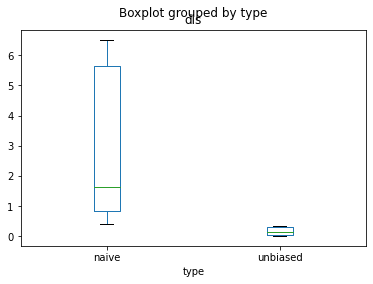

In [663]:
pd.DataFrame.from_records(result, columns = ['type','dis']).boxplot(by ='type', column =['dis'], grid = False, showfliers=False)

In [59]:
# For join

# DP parameters
eps = 1
delta = 0.05
bound = 10

# data parameters
buyer_att = 2
seller_att = 1
num_att = buyer_att + seller_att
num_group = 10
num_rows_per_group = 3000
num_rows = num_group * num_rows_per_group
columns = [f"f{i}" for i in range(num_att)]
buyer_columns = columns[:buyer_att]
seller_columns = columns[buyer_att:]


# create data
mean, cov = get_pos_def_mean_cov(num_att)
df = pd.DataFrame(np.random.multivariate_normal(mean, cov, num_rows), columns=columns)
clip_data(df, bound)
joinkey = []
for i in range(num_group):
    joinkey += [i] * num_rows_per_group 
df["join_key"] = joinkey
# bound = get_l2_bound(df)

# multiplied by 2 because of histogram
sensitivity = 2*(bound**4 + bound**2 + 1)**0.5

# we use the original dataset without noise as testing data
buyeragg = agg_dataset()
buyeragg.load(df[buyer_columns + ["join_key"]].copy(deep=True), buyer_columns, ["join_key"])
buyeragg.compute_agg()

selleragg = agg_dataset()
selleragg.load(df[seller_columns + ["join_key"]].copy(deep=True), seller_columns, ["join_key"])
selleragg.compute_agg()

join_train = join_agg(selleragg, buyeragg, "join_key")
join_train_cov = join_train.sum()
join_unbiased_train_cov = unbiased_est(join_train_cov.copy(deep=True), buyer_att, seller_att, num_group, num_rows_per_group)

X = columns[1:]
y = columns[0]
ridge = 0
unbiased_parameter = ridge_linear_regression(join_unbiased_train_cov, X, y, ridge)

noise = compute_std(eps, delta, sensitivity)

# impute noise
for col in selleragg.semi_ring_columns():
    selleragg.agg_dimensions["join_key"][col] += np.random.normal(0, noise, len(selleragg.agg_dimensions["join_key"]))

for col in buyeragg.semi_ring_columns():
    buyeragg.agg_dimensions["join_key"][col] += np.random.normal(0, noise, len(buyeragg.agg_dimensions["join_key"]))

join_train = join_agg(selleragg, buyeragg, "join_key")
join_train_cov = join_train.sum()
join_unbiased_train_cov = unbiased_est(join_train_cov.copy(deep=True), buyer_att, seller_att, num_group, num_rows_per_group)
noisy_parameter = ridge_linear_regression(join_unbiased_train_cov, X, y, ridge)

get_l2_distance(unbiased_parameter, noisy_parameter)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


0.6988588103522232

In [688]:
# study the effects of multiplicity
result = []

# DP parameters
eps = 1
delta = 0.05
bound = 10



for num_rows_per_group in [100, 500, 1000, 5000]:
    for _ in range(10):
        # data parameters
        buyer_att = 2
        seller_att = 1
        num_att = buyer_att + seller_att
        num_group = 3
        num_rows_per_group = num_rows_per_group
        num_rows = num_group * num_rows_per_group
        columns = [f"f{i}" for i in range(num_att)]
        buyer_columns = columns[:buyer_att]
        seller_columns = columns[buyer_att:]


        # create data
        mean, cov = get_pos_def_mean_cov(num_att)
        df = pd.DataFrame(np.random.multivariate_normal(mean, cov, num_rows), columns=columns)
        clip_data(df, bound)
        joinkey = []
        for i in range(num_group):
            joinkey += [i] * num_rows_per_group 
        df["join_key"] = joinkey
        # bound = get_l2_bound(df)

        # multiplied by 2 because of histogram
        sensitivity = 2*(bound**4 + bound**2 + 1)**0.5

        # we use the original dataset without noise as testing data
        buyeragg = agg_dataset()
        buyeragg.load(df[buyer_columns + ["join_key"]].copy(deep=True), buyer_columns, ["join_key"])
        buyeragg.compute_agg()

        selleragg = agg_dataset()
        selleragg.load(df[seller_columns + ["join_key"]].copy(deep=True), seller_columns, ["join_key"])
        selleragg.compute_agg()

        join_train = join_agg(selleragg, buyeragg, "join_key")
        join_train_cov = join_train.sum()
        join_unbiased_train_cov = unbiased_est(join_train_cov.copy(deep=True), buyer_att, seller_att, num_group, num_rows_per_group)

        X = columns[1:]
        y = columns[0]
        ridge = 0
        unbiased_parameter = ridge_linear_regression(join_unbiased_train_cov, X, y, ridge)

        noise = compute_std(eps, delta, sensitivity)

        # impute noise
        for col in selleragg.semi_ring_columns():
            selleragg.agg_dimensions["join_key"][col] += np.random.normal(0, noise, len(selleragg.agg_dimensions["join_key"]))

        for col in buyeragg.semi_ring_columns():
            buyeragg.agg_dimensions["join_key"][col] += np.random.normal(0, noise, len(buyeragg.agg_dimensions["join_key"]))

        join_train = join_agg(selleragg, buyeragg, "join_key")
        join_train_cov = join_train.sum()
        join_unbiased_train_cov = unbiased_est(join_train_cov.copy(deep=True), buyer_att, seller_att, num_group, num_rows_per_group)
        noisy_parameter = ridge_linear_regression(join_unbiased_train_cov, X, y, ridge)

        dis = get_l2_distance(unbiased_parameter, noisy_parameter)
        result.append([num_rows_per_group,dis])

/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  join.drop('cov:c_y', 1, inplace=True)
/tmp/ipykernel_2125068/4232687330.py:145: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument '

<AxesSubplot:title={'center':'dis'}, xlabel='num_rows_per_group'>

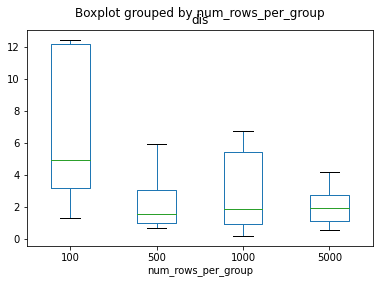

In [689]:
pd.DataFrame.from_records(result, columns = ['num_rows_per_group','dis']).boxplot(by ='num_rows_per_group', column =['dis'], grid = False, showfliers=False)